In [1]:
!pip install qiskit

In [2]:
# for verification
!pip install mqt.qcec==2.0.0rc1

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
import numpy as np
from math import pi, sqrt
import random
import sys
import os
from qiskit.test.mock import FakeAthens
from mqt import qcec

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# remove all previous profiles

directory = os.getcwd()
test = os.listdir( directory )

for item in test:
    if item.endswith(".txt"):
        os.remove( os.path.join( directory, item ) )

In [5]:
# single qubit gates with no parameters
single_qubit_gates_no_params = ["x","y","z","h","s","sdg","t","tdg","sx","sxdg"]

# single qubit gates with no parameters
single_qubit_gates_1_params = ["p","rx","ry","rz"]

# single qubit gates with 2 parameters
single_qubit_gates_2_params = ["u2"]

# single qubit gates with 3 parameters
single_qubit_gates_3_params = ["u3"]

# single qubit gates with 3 parameters
two_qubit_gates = ["swap", "iswap"]

#creating the gate statistics list
gate_stats = []

# the basis gates
basis_gates = ['id', 'rz', 'sx', 'x', 'cx']

# create gate (with params) and return it
def create_gate_with_params(circuit, gate, number_qubits, number_params):
    if number_qubits == 1:
        param_list = []

        for i in range(number_params):
            param_list.append(random.uniform(-np.pi, np.pi))

        getattr(circuit, gate)(*param_list, 0)
    elif number_qubits == 2:
        getattr(circuit, gate)(0, 1)

    return circuit

# return gate with number of controls
def create_controlled_gate(circuit, controls, number_qubits):
    # convert circuit to gate and add number of controls
    custom_circuit = circuit.to_gate().control(controls)

    # create new circuit with number of qubits for gate + for controls
    circuit_with_controls = QuantumCircuit(controls + number_qubits)

    # append gate with controls to circuit with controls
    # second argument is a range for number of controls
    circuit_with_controls.append(custom_circuit, range(controls + number_qubits))
    
    return circuit_with_controls


# create look up table for set of gates
# with different amounts of controls
def create_lookup_table(gates, basis_gates, number_qubits, number_params, max_controls, optimization_level):
    
    # iterate through each gate
    for gate in gates:
        
        # create circuit with all amount of controls
        for controls in range(0, max_controls + 1):
            
            # create single qubit circuit
            circuit = QuantumCircuit(number_qubits)

            # create gate with its params
            circuit = create_gate_with_params(circuit, gate, number_qubits, number_params)
        
            # if there are controls,
            # create circuit with controls
            if controls != 0:
                circuit_with_controls = create_controlled_gate(circuit, controls, number_qubits)
                
                # set circuit that will be transpiled to the circuit with controls
                circuit = circuit_with_controls
                
            # transpile the circuit
            transpiled_circuit = transpile(circuit, basis_gates = basis_gates, optimization_level=optimization_level)
            gate_stats.append([gate,controls, transpiled_circuit.size()])
    
    # creating and writing the profiles to text file
    cd = os.getcwd()

    #creating a txt file with name "gate_status_op_lv_n.txt", n being the optimization level
    f = open(cd + "/gate_stats" + "_op_lv_" + str(optimization_level) + ".txt", "a")

    #writing the information from gate_stats list to the text file
    for i in np.arange(len(gate_stats)):
        f.writelines([gate_stats[i][0], " ", str(gate_stats[i][1]), " ", str(gate_stats[i][2])])
        f.writelines(['\n'])
    
    f.close()

In [6]:
#example execution of function
for optimization_level in range(4):
    create_lookup_table(single_qubit_gates_no_params, basis_gates, 1, 0, 5, optimization_level)
    create_lookup_table(single_qubit_gates_1_params, basis_gates, 1, 1, 5, optimization_level)
    create_lookup_table(single_qubit_gates_2_params, basis_gates, 1, 2, 5, optimization_level)
    create_lookup_table(single_qubit_gates_3_params, basis_gates, 1, 3, 5, optimization_level)
    create_lookup_table(two_qubit_gates, basis_gates, 2, 0, 5, optimization_level)


/tmp/ipykernel_1211/1510244086.py:30: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  getattr(circuit, gate)(*param_list, 0)
/tmp/ipykernel_1211/1510244086.py:30: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  getattr(circuit, gate)(*param_list, 0)
/tmp/ipykernel_1211/1510244086.py:30: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.1

In [15]:
# verification

def verify_circuit(circuit_original, circuit_compiled, optimization_level):
    # initialize the equivalence checker
    ecm = qcec.EquivalenceCheckingManager(circuit_original, circuit_compiled)

    # set the application scheme to be based off a profile
    ecm.set_application_scheme('gate_cost')
    ecm.set_gate_cost_profile('gate_stats_op_lv_' + str(optimization_level) + '.txt') # Omar changed this to .txt

    # execute the check
    ecm.run()

    # obtain the result
    # string
    regular_equivalence = ecm.equivalence()
    # boolean
    considered_equivalent = ecm.get_results().considered_equivalent()
    # obtain runtime
    results = ecm.get_results()
    runtime = 'Took:' + str(results.check_time) + '[s]'
    
    return (regular_equivalence, considered_equivalent, runtime)


In [17]:
# TEST CASE FOR VERIFICATION

# original circuit
circ = QuantumCircuit(3)
circ.h(0)
circ.cx(0, 1)
circ.cx(0, 2)
circ.ccx(0, 2, 1)
circ.measure_all()
circ.draw(fold=-1)

# compile circuit to 5 qubit London Architecture
circ_comp = transpile(circ, backend=FakeAthens(), optimization_level = 3)
circ_comp.draw(fold=-1)

results = verify_circuit(circ, circ_comp, 3)
for item in results:
    print(item)


equivalent_up_to_global_phase
True
Took:0.052598311[s]


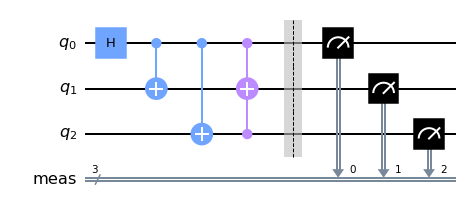

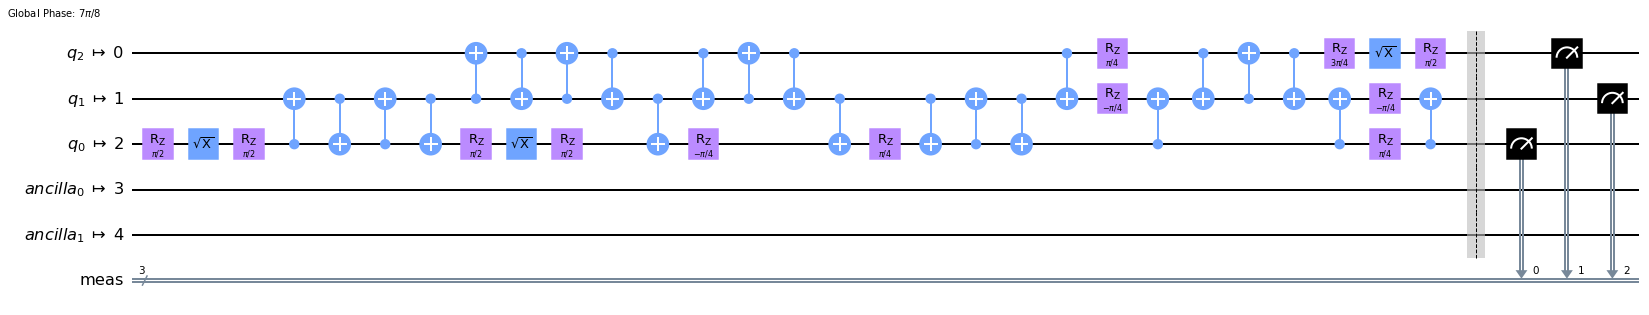

equivalent_up_to_global_phase
----------
True
Took: 0.13156316 [s]
